# Analysis of StackOverflow Survey. Part IV 

In this notebook we build a predictiv model for job satisfaction. 

In [1]:
# import neccessary packages and libraries
import os
from collections import defaultdict

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
# to render plots in the notebook
%matplotlib inline

import seaborn as sns
# set a theme for seaborn
sns.set_theme()

from sklearn.linear_model import LinearRegression
from sklearn.impute import KNNImputer
from sklearn.dummy import DummyClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import SelectKBest, chi2, mutual_info_classif

from sklearn import (
    ensemble,
    preprocessing,
    tree,
)
from sklearn.model_selection import (
    train_test_split,
    StratifiedKFold,
)
from sklearn.metrics import (
    classification_report,
    r2_score, 
    mean_squared_error,
    auc,
    confusion_matrix,
    accuracy_score,
    roc_auc_score,
    roc_curve,
)


In [2]:
# import local module containing the neccessary functions
import utils_functions as uf

# forces the interpreter to re-import the module
import importlib
importlib.reload(uf);

## State the question
I am addressing the third question in this notebook. What can we tell about the job satisfaction of a data coder? What factors do influence it? Also, predict the job satisfaction for a developer who works with big data. 

This is a classification question, we are predicting a satisfaction level for a data developer, which includes: data scientist or machine learning specialist, data or business analyst and data engineer.

## Performance metrics - to review at the end

The following performance measures will be used in this project:
1. Cross validation via StratifiedKFold with 10 folds.
2. Confusion matrix, in particular precision, recall and F1 score.
3. The ROC curve and the related AUC score.

## Gather and prepare the data

Upload the data and keep the subset that contains those developers that work in data science related fields. 

Manually inspect (using the profiling html file, for example) the remaining columns and drop the following columns: 
 - DevClass, Country both introduce noise in the model,
 - JobFactors, Stuck, PlatformWorkedWith they consist of numerous string combinations, as a result of multiple options and choices, the columns have high cardinality and many missing values.

In [3]:
# create a path string
mypath = os.getcwd()

# upload the datafiles as pandas dataframes
df1 = pd.read_csv(mypath+'/data/survey20_updated.csv', index_col=[0])

# check the uploaded data
df1.shape

(64217, 21)

In [4]:
# the data frame that contains the data developers only
df1 = df1[df1.DevClass == 'data_coder']

In [5]:
# drop the columns mentioned above
df1.drop(columns=['DevClass', 'Country', 'JobFactors', 'Stuck', 'PlatformWorkedWith'], inplace=True)

# check for success
df1.columns

Index(['Age', 'ConvertedComp', 'EdLevel', 'Employment', 'JobSat', 'JobSeek',
       'DevOpsImpt', 'EdImpt', 'Learn', 'OnboardGood', 'Overtime', 'OpSys',
       'OrgSize', 'UndergradMajor', 'WorkWeekHrs', 'YearsCode'],
      dtype='object')

In [6]:
# create a list of columns to be used in this analysis
#list_cols = ['MainBranch', 'ConvertedComp', 'EdLevel', 'Employment', 'JobSat', 'EdImpt',
       #'Learn', 'Overtime', 'OpSys', 'OrgSize','UndergradMajor', 'WorkWeekHrs']

    # the dataset that contains only the listed columns
#df1 = df1[list_cols]

## Data profiling

In [7]:
# run this once to generate a profiling report and save it as html file

#import pandas_profiling
#profile = pandas_profiling.ProfileReport(df, minimal=False)
#profile.to_file(output_file="data_coders_report.html")

## Data preprocessing 

### Drop rows based on the Employment column

In [8]:
# check possible Employment choices
employment = df1.Employment.value_counts().index.to_list()
employment

['Employed full-time',
 'Independent contractor, freelancer, or self-employed',
 'Not employed, but looking for work',
 'Employed part-time']

In [9]:
# retain only the employed data davelopers
df1 = df1[df1['Employment'] != 'Not employed, but looking for work']

# check for success
df1.Employment.value_counts()

Employed full-time                                      6875
Independent contractor, freelancer, or self-employed    1062
Employed part-time                                       352
Name: Employment, dtype: int64

### Create bins for the WorkWeekHrs column

In [10]:
# create the labels
cut_labels = ['less-10', '10-20', '20-30', '30-40', '40-50', 'more-50']

# define the bins 
m = df1.WorkWeekHrs.max()
cut_bins = [0, 10, 20, 30, 40, 50, m]

# create a new column which contains the new labels
df1['WorkWeek_Bins'] = pd.cut(df1['WorkWeekHrs'], bins=cut_bins, labels=cut_labels)

# check for success
df1['WorkWeek_Bins'].value_counts()

30-40      3848
40-50      1837
more-50     563
less-10     284
20-30       276
10-20       140
Name: WorkWeek_Bins, dtype: int64

In [11]:
# change the type of the newly created column
df1['WorkWeek_Bins'] = df1['WorkWeek_Bins'].astype('object')

In [12]:
# drop the WorkWeekHrs column
df1.drop(columns = 'WorkWeekHrs', inplace=True);

### Create bins for the ConvertedComp column

In [13]:
# we could use quantile, however I prefer custom bins here
cut_labels = ['less-10K', '10K-30K', '30K-50K', '50K-100K', '100K-200K', 'more-200K']

# define the bins 
m = df1.ConvertedComp.max()
cut_bins = [0, 10000, 30000, 50000, 100000, 200000, m]

# create a new column which contains the new labels
df1['Comp_Bins'] = pd.cut(df1['ConvertedComp'], bins=cut_bins, labels=cut_labels)

# change the type of the newly created column
df1['Comp_Bins'] = df1['Comp_Bins'].astype('object')

# drop the WorkWeekHrs column
df1.drop(columns = 'ConvertedComp', inplace=True);

### Create bins for the Age column

In [14]:
# define the bin edges
cut_labels = ['<20', '20-30', '30-40', '40-50', '50-60', '60-70', '70-80', '>80']

# define the bins 
m = df1.Age.max()
cut_bins = [0, 20, 30, 40, 50, 60, 70, 80, m]

# create a new column which contains the new labels
df1['Age_Bins'] = pd.cut(df1['Age'], bins=cut_bins, labels=cut_labels)

# change the type of the newly created column
df1['Age_Bins'] = df1['Age_Bins'].astype('object')

# drop the WorkWeekHrs column
df1.drop(columns = 'Age', inplace=True);

### Remove the rows that contain mostly missing values

In [15]:
# keep only the rows with at least 10 non-NA values
df1.dropna(thresh=10)

# check the result
df1.shape

(8289, 16)

In [16]:
df1.JobSat.isnull().sum()

601

In [17]:
df1.dropna( how='any', subset=['JobSat'], inplace=True)

In [18]:
df1.JobSat.isnull().sum()

0

### Remove duplicates

In [19]:
# drop duplicate rows, if any
df1.drop_duplicates(subset=None, keep='first', inplace=True)
df1.shape

(7687, 16)

## Create features and target

Create a dataframe (X) with the features and a pandas series (y) that contains the labels.

In [20]:
# create a copy of the pre-processed dataframe
df2 = df1.copy()

In [21]:
# create the predictors dataframe
X = df2.drop(columns = 'JobSat')

# create the labels
y = df2['JobSat']

# check for success
X.info(), len(y)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7687 entries, 21 to 64127
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   EdLevel         7577 non-null   object
 1   Employment      7687 non-null   object
 2   JobSeek         7268 non-null   object
 3   DevOpsImpt      7069 non-null   object
 4   EdImpt          7566 non-null   object
 5   Learn           7089 non-null   object
 6   OnboardGood     7260 non-null   object
 7   Overtime        7357 non-null   object
 8   OpSys           7191 non-null   object
 9   OrgSize         7527 non-null   object
 10  UndergradMajor  7186 non-null   object
 11  YearsCode       7619 non-null   object
 12  WorkWeek_Bins   6930 non-null   object
 13  Comp_Bins       5738 non-null   object
 14  Age_Bins        6084 non-null   object
dtypes: object(15)
memory usage: 960.9+ KB


(None, 7687)

In [22]:
# format all the fields as strings in the feature matrix
X = X.astype(str)

## Sample data

We will use $30 \%$ data for testing:

In [23]:
# split the data in train and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# summarize the data
print('Train', X_train.shape, y_train.shape)
print('Test', X_test.shape, y_test.shape)

Train (5380, 15) (5380,)
Test (2307, 15) (2307,)


## Impute missing values

Now that we have test and train data, we can impute missing values on the training set, and use the trained imputer to fill in the test dataset. I will use the KNN imputer from sklearn.

In [24]:
# create an instance of the imputer
#imputer = KNNImputer(n_neighbors=5)

# fit the imputer on the dataset
#X_train_trans = pd.DataFrame(imputer.fit_transform(X_train), columns = X_train.columns)

# check for success
#X_train_trans.isna().any()
from sklearn.impute import SimpleImputer
def impute_predictors(X_train, X_test):
    imputer = SimpleImputer(strategy='constant', fill_value='missing')
    imputer.fit(X_train)
    X_train_trans = pd.DataFrame(imputer.transform(X_train), columns=X_train.columns)
    X_test_trans = pd.DataFrame(imputer.transform(X_test), columns=X_test.columns)
    return X_train_trans, X_test_trans

In [25]:
X_train_trans, X_test_trans = impute_predictors(X_train, X_test)

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('encoder', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', categorical_transformer, [0])
    ])

In [26]:
X_train_trans.isna().sum()

EdLevel           0
Employment        0
JobSeek           0
DevOpsImpt        0
EdImpt            0
Learn             0
OnboardGood       0
Overtime          0
OpSys             0
OrgSize           0
UndergradMajor    0
YearsCode         0
WorkWeek_Bins     0
Comp_Bins         0
Age_Bins          0
dtype: int64

## Encode the data

The best practice when encoding variables is to fit the encoding on the training dataset, then apply it to the train and test datasets.

The function below named prepare_inputs() takes the input data for the train and test

In [27]:
 # prepare input data
def encode_predictors(X_train, X_test):
	enc = OneHotEncoder(handle_unknown='ignore')
	enc.fit(X_train)
	X_train_enc = enc.transform(X_train)
	X_test_enc = enc.transform(X_test)
	return X_train_enc, X_test_enc

In [30]:
X_train_enc, X_test_enc = encode_predictors(X_train_trans, X_test_trans)

In [31]:
X_train_enc

<5380x148 sparse matrix of type '<class 'numpy.float64'>'
	with 80700 stored elements in Compressed Sparse Row format>

Regarding the output data, the target, since it is already encoded as an integer with values from 0 to 5, no other encoding steps are needed at this point.

Alternative would be:

In [32]:
# prepare target
#def encode_targets(y_train, y_test):
	#le = LabelEncoder()
	#le.fit(y_train)
	#y_train_enc = le.transform(y_train)
	#y_test_enc = le.transform(y_test)
	#return y_train_enc, y_test_enc

### Perform feature selection



In [33]:
# feature selection
def select_features(X_train, y_train, X_test):
	fs = SelectKBest(score_func=mutual_info_classif, k=20)
	fs.fit(X_train, y_train)
	X_train_fs = fs.transform(X_train)
	X_test_fs = fs.transform(X_test)
	return X_train_fs, X_test_fs, fs


In [34]:
X_train_fs, X_test_fs, fs = select_features(X_train_enc, y_train, X_test_enc)

In [35]:
# what are scores for the features
#for i in range(len(fs.scores_)):
	#print('Feature %d: %f' % (i, fs.scores_[i]))

<BarContainer object of 148 artists>

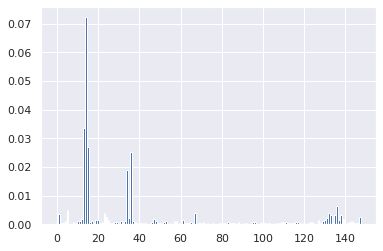

In [36]:
# plot the scores
plt.bar([i for i in range(len(fs.scores_))], fs.scores_)


In [149]:
mi = pd.Series(fs.scores_)


## Refactor code


In [97]:
X_train_fs

<5380x20 sparse matrix of type '<class 'numpy.float64'>'
	with 24431 stored elements in Compressed Sparse Row format>

In [3]:
# create a path string
mypath = os.getcwd()

# read the data from the file
df = pd.read_csv(mypath+'/data/survey20_updated.csv')
# preprocess, split and process data
preproc_df = uf.preprocess_data(df)
X_train, y_train, X_test, y_test = uf.process_data(preproc_df, 'JobSat')

## Baseline model: K NearestNeighbors

In [37]:
# create an instance of the classifier
knn_clf = KNeighborsClassifier(n_neighbors=5)

# fit the classifier
knn_clf.fit(X_train_fs, y_train)

# predict output values
y_pred = knn_clf.predict(X_test_fs)

In [38]:
# print evaluation metrics and results

result1 = confusion_matrix(y_test, y_pred)
print('Confusion Matrix:')
print(result1)

result2 = classification_report(y_test, y_pred)
print('\nClassification Report:')
print (result2)

result3 = accuracy_score(y_test,y_pred)  
print('Accuracy: %.3f' %result3)
         

Confusion Matrix:
[[ 26  37  19  43  60]
 [ 36 100  28 131  57]
 [ 19  73  39 104  46]
 [ 32 160  65 281 157]
 [ 33 105  47 215 394]]

Classification Report:
              precision    recall  f1-score   support

         1.0       0.18      0.14      0.16       185
         2.0       0.21      0.28      0.24       352
         3.0       0.20      0.14      0.16       281
         4.0       0.36      0.40      0.38       695
         5.0       0.55      0.50      0.52       794

    accuracy                           0.36      2307
   macro avg       0.30      0.29      0.29      2307
weighted avg       0.37      0.36      0.36      2307

Accuracy: 0.364


## Several other algorithms 

In [39]:
from sklearn.svm import SVC

# create classifier instance
svm_clf = SVC(gamma="auto", random_state=42)
# fit the model
svm_clf.fit(X_train_fs, y_train)

SVC(gamma='auto', random_state=42)

In [40]:
# predict on the test set
y_pred = svm_clf.predict(X_test_fs)

# test one value
y_test.iloc[20],  y_pred[20]

(4.0, 2.0)

In [41]:
some_digit_scores = svm_clf.decision_function(X_test_fs)
some_digit_scores[20]

array([ 1.96792161,  4.26910282,  0.77959714,  3.21192879, -0.26498715])

In [42]:
np.argmax(some_digit_scores[20])

1

In [43]:
svm_clf.classes_

array([1., 2., 3., 4., 5.])

In [44]:
y_test.values[0]

3.0

In [48]:
from sklearn.model_selection import cross_val_score
cross_val_score(svm_clf, X_test_fs, y_test, cv=10, scoring="accuracy")

array([0.40692641, 0.38961039, 0.38961039, 0.44588745, 0.41991342,
       0.38095238, 0.43290043, 0.46086957, 0.38695652, 0.4173913 ])

In [49]:
# print evaluation metrics and results

result1 = confusion_matrix(y_test, y_pred)
print('Confusion Matrix:')
print(result1)

result2 = classification_report(y_test, y_pred, zero_division=0)
print('\nClassification Report:')
print (result2)

result3 = accuracy_score(y_test,y_pred)  
print('Accuracy: %.3f' %result3)
         

Confusion Matrix:
[[  0  57   0  75  53]
 [  0  94   0 225  33]
 [  0  50   0 200  31]
 [  0  80   0 501 114]
 [  0  30   0 379 385]]

Classification Report:
              precision    recall  f1-score   support

         1.0       0.00      0.00      0.00       185
         2.0       0.30      0.27      0.28       352
         3.0       0.00      0.00      0.00       281
         4.0       0.36      0.72      0.48       695
         5.0       0.62      0.48      0.55       794

    accuracy                           0.42      2307
   macro avg       0.26      0.29      0.26      2307
weighted avg       0.37      0.42      0.38      2307

Accuracy: 0.425


In [50]:
from sklearn.multiclass import OneVsRestClassifier
ovr_clf = OneVsRestClassifier(SVC(gamma="auto", random_state=42))
ovr_clf.fit(X_train_fs, y_train)
y_pred = ovr_clf.predict(X_test_fs)

In [51]:
result1 = confusion_matrix(y_test, y_pred)
print('Confusion Matrix:')
print(result1)

result2 = classification_report(y_test, y_pred, zero_division=0)
print('\nClassification Report:')
print (result2)

result3 = accuracy_score(y_test,y_pred)  
print('Accuracy: %.3f' %result3)

Confusion Matrix:
[[ 20  35   8  29  93]
 [ 35  68  29 119 101]
 [ 28  47  14 101  91]
 [ 49 100  48 226 272]
 [ 26  63  41 134 530]]

Classification Report:
              precision    recall  f1-score   support

         1.0       0.13      0.11      0.12       185
         2.0       0.22      0.19      0.20       352
         3.0       0.10      0.05      0.07       281
         4.0       0.37      0.33      0.35       695
         5.0       0.49      0.67      0.56       794

    accuracy                           0.37      2307
   macro avg       0.26      0.27      0.26      2307
weighted avg       0.34      0.37      0.35      2307

Accuracy: 0.372


In [52]:
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

# Always scale the input. The most convenient way is to use a pipeline.
sgd_clf = make_pipeline(StandardScaler(with_mean=False),SGDClassifier(max_iter=1000, tol=1e-3))
sgd_clf.fit(X_train_fs, y_train)
y_pred = sgd_clf.predict(X_test_fs)

In [53]:
result1 = confusion_matrix(y_test, y_pred)
print('Confusion Matrix:')
print(result1)

result2 = classification_report(y_test, y_pred, zero_division=0)
print('\nClassification Report:')
print (result2)

result3 = accuracy_score(y_test,y_pred)  
print('Accuracy: %.3f' %result3)

Confusion Matrix:
[[ 25  20   0  58  82]
 [ 51  33   1 174  93]
 [ 23  24   0 147  87]
 [ 56  42   1 359 237]
 [ 32  16   0 254 492]]

Classification Report:
              precision    recall  f1-score   support

         1.0       0.13      0.14      0.13       185
         2.0       0.24      0.09      0.14       352
         3.0       0.00      0.00      0.00       281
         4.0       0.36      0.52      0.43       695
         5.0       0.50      0.62      0.55       794

    accuracy                           0.39      2307
   macro avg       0.25      0.27      0.25      2307
weighted avg       0.33      0.39      0.35      2307

Accuracy: 0.394


In [54]:
X = pd.concat([X_train_fs, X_test_fs])
y = pd.concat([y_train, y_test])

TypeError: cannot concatenate object of type '<class 'scipy.sparse.csr.csr_matrix'>'; only Series and DataFrame objs are valid

In [55]:
from sklearn import model_selection
from sklearn.linear_model import (LogisticRegression)
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import (KNeighborsClassifier)
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import (RandomForestClassifier)
import xgboost as xgb
from sklearn.metrics import classification_report

In [56]:
for model in [DecisionTreeClassifier, KNeighborsClassifier, GaussianNB, SVC, 
              RandomForestClassifier, SGDClassifier]:
    make_pipeline(StandardScaler(),model())
    classifier = model()
    kfold = model_selection.KFold(n_splits=10)
    classifier.fit(X_train_fs.toarray(), y_train)
    s = model_selection.cross_val_score(classifier, X_test_fs.toarray(),y_test, cv=kfold)
    #result2 = classification_report(y_test, y_pred, zero_division=0)
    #s = model_selection.cross_val_score(cls, X, y, cv=kfold)
    print(f"{model.__name__:22}  CV_Mean:" f"{s.mean():.3f} CV_STD: {s.std():.2f}")

DecisionTreeClassifier  CV_Mean:0.300 CV_STD: 0.03
KNeighborsClassifier    CV_Mean:0.343 CV_STD: 0.03
GaussianNB              CV_Mean:0.393 CV_STD: 0.02
SVC                     CV_Mean:0.416 CV_STD: 0.03
RandomForestClassifier  CV_Mean:0.336 CV_STD: 0.03
SGDClassifier           CV_Mean:0.375 CV_STD: 0.03


In [57]:
xgb_model = xgb.XGBClassifier(objective="multi:softprob", random_state=42)
xgb_model.fit(X_train_fs, y_train)


XGBClassifier(objective='multi:softprob', random_state=42)

In [59]:
y_pred = xgb_model.predict(X_test_fs)

print(confusion_matrix(y_test, y_pred))

[[  7  35   2  60  81]
 [  8  64   2 197  81]
 [  3  29   1 180  68]
 [  6  44   1 413 231]
 [  5  12   1 262 514]]


In [61]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         1.0       0.24      0.04      0.07       185
         2.0       0.35      0.18      0.24       352
         3.0       0.14      0.00      0.01       281
         4.0       0.37      0.59      0.46       695
         5.0       0.53      0.65      0.58       794

    accuracy                           0.43      2307
   macro avg       0.33      0.29      0.27      2307
weighted avg       0.38      0.43      0.38      2307



In [67]:
import numpy as np

from scipy.stats import uniform, randint

from sklearn.datasets import load_breast_cancer, load_diabetes, load_wine
from sklearn.metrics import auc, accuracy_score, confusion_matrix, mean_squared_error
from sklearn.model_selection import cross_val_score, GridSearchCV, KFold, RandomizedSearchCV, train_test_split

In [69]:
xgb_model = xgb.XGBClassifier(objective="multi:softprob", random_state=42)

params = {
    "colsample_bytree": uniform(0.7, 0.3),
    "gamma": uniform(0, 0.5),
    "learning_rate": uniform(0.03, 0.3), # default 0.1 
    "max_depth": randint(2, 6), # default 3
    "n_estimators": randint(100, 150), # default 100
    "subsample": uniform(0.6, 0.4)
}

search = RandomizedSearchCV(xgb_model, param_distributions=params, random_state=42, 
                            n_iter=200, cv=3, verbose=1, n_jobs=1, return_train_score=True)

search.fit(X_train_fs, y_train)

#report_best_scores(search.cv_results_, 1)

Fitting 3 folds for each of 200 candidates, totalling 600 fits


RandomizedSearchCV(cv=3,
                   estimator=XGBClassifier(objective='multi:softprob',
                                           random_state=42),
                   n_iter=200, n_jobs=1,
                   param_distributions={'colsample_bytree': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7feb4b7e63d0>,
                                        'gamma': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7feb4b7e6190>,
                                        'learning_rate': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7feb4b7e6950>,
                                        'max_depth': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7feb5007d410>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7feb5007db50>,
                                        'subsample': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7feb5007d590>},
                   random_state=42, retur

In [73]:
search.cv_results_['mean_test_score']

array([0.43401732, 0.39089574, 0.43308726, 0.41134067, 0.41914684,
       0.4109675 , 0.4332742 , 0.4236077 , 0.43717713, 0.43531816,
       0.40743794, 0.4128269 , 0.41654496, 0.39535547, 0.41821771,
       0.43290145, 0.41710258, 0.43197233, 0.41357001, 0.43587609,
       0.40836583, 0.43587609, 0.4316002 , 0.42936972, 0.43327317,
       0.43308653, 0.41673086, 0.42286418, 0.43123004, 0.417289  ,
       0.42342128, 0.43308788, 0.43531836, 0.43383058, 0.39126746,
       0.43401732, 0.43383079, 0.41543034, 0.42174966, 0.39702968,
       0.43550396, 0.42416626, 0.41635812, 0.42565311, 0.40390641,
       0.39758668, 0.43160103, 0.433274  , 0.41078305, 0.43717724,
       0.42881189, 0.41431458, 0.43420302, 0.43197326, 0.43234435,
       0.41784579, 0.43401628, 0.43661879, 0.43513194, 0.42565207,
       0.42398004, 0.43345856, 0.43847735, 0.42156323, 0.43457463,
       0.40576518, 0.43568966, 0.43420271, 0.40167541, 0.41765978,
       0.42825479, 0.40297635, 0.43606189, 0.4362479 , 0.39349

In [70]:
search.best_params_

{'colsample_bytree': 0.7719362077472209,
 'gamma': 0.046936645040645875,
 'learning_rate': 0.08485979913219219,
 'max_depth': 2,
 'n_estimators': 100,
 'subsample': 0.9819461122652776}

In [ ]:
#from stack
clf_xgb = xgb.XGBClassifier(objective = 'binary:logistic')
param_dist = {'n_estimators': stats.randint(150, 1000),
              'learning_rate': stats.uniform(0.01, 0.59),
              'subsample': stats.uniform(0.3, 0.6),
              'max_depth': [3, 4, 5, 6, 7, 8, 9],
              'colsample_bytree': stats.uniform(0.5, 0.4),
              'min_child_weight': [1, 2, 3, 4]
             }

numFolds = 5
kfold_5 = cross_validation.KFold(n = len(X), shuffle = True, n_folds = numFolds)

clf = RandomizedSearchCV(clf_xgb, 
                         param_distributions = param_dist,
                         cv = kfold_5,  
                         n_iter = 5, # you want 5 here not 25 if I understand you correctly 
                         scoring = 'roc_auc', 
                         error_score = 0, 
                         verbose = 3, 
                         n_jobs = -1)

In [64]:
from sklearn.model_selection import KFold
kfold = KFold(n_splits=5, shuffle=True, random_state=42)

scores = []

for train_index, test_index in kfold.split(X_train_fs):   
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    xgb_model = xgb.XGBClassifier(objective="multi:softprob", random_state=42)
    xgb_model.fit(X_train_fs, y_train)
    
    y_pred = xgb_model.predict(X_test_fs)
    
    scores.append(mean_squared_error(y_test, y_pred))
    
display_scores(np.sqrt(scores))

KeyError: "None of [Int64Index([   0,    1,    2,    3,    4,    5,    6,    7,    9,   10,\n            ...\n            5365, 5366, 5368, 5369, 5371, 5372, 5375, 5377, 5378, 5379],\n           dtype='int64', length=4304)] are in the [columns]"

In [22]:
cls = RandomForestClassifier()
kfold = model_selection.KFold(n_splits=10)
s = model_selection.cross_val_score(cls, X,y, cv=kfold)

In [24]:
cls_rf = RandomForestClassifier()
kfold = model_selection.KFold(n_splits=10)
cls_rf.fit(X_train, y_train)
y_pred = cls_rf.predict(X_test)
s = model_selection.cross_val_score(cls_rf, X_test,y_test, cv=kfold)

In [ ]:
print(classification_report(y_test, y_pred, target_names=labels))

In [45]:
df1 = pd.read_csv(mypath+'/data/survey20_updated.csv')

In [46]:
df1.shape

(64461, 25)

In [47]:
df1 = df1[df1['JobSat'] !=0]

In [48]:
df1.shape

(45194, 25)

In [49]:
df1.JobSat.value_counts()

5    14611
4    13930
2     7124
3     5783
1     3746
Name: JobSat, dtype: int64

In [50]:
# read the data from the file
#df = pd.read_csv(mypath+'/data/survey20_updated.csv')
# preprocess, split and process data
preproc_df1 = uf.preprocess_data(df1)
X1_train, y1_train, X1_test, y1_test = uf.process_data(preproc_df1, 'JobSat')

In [55]:
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

# Always scale the input. The most convenient way is to use a pipeline.
sgd_clf = make_pipeline(StandardScaler(),SGDClassifier(max_iter=1000, tol=1e-3))
sgd_clf.fit(X1_train, y1_train)
y1_pred = sgd_clf.predict(X1_test)

In [56]:
result1 = confusion_matrix(y1_test, y1_pred)
print('Confusion Matrix:')
print(result1)

result2 = classification_report(y1_test, y1_pred, zero_division=0)
print('\nClassification Report:')
print (result2)

result3 = accuracy_score(y1_test,y1_pred)  
print('Accuracy: %.3f' %result3)

Confusion Matrix:
[[  8  24   8  60  81]
 [ 21  33  33 149 127]
 [ 17  30  22 109  96]
 [ 36  64  44 270 300]
 [ 33  76  56 278 343]]

Classification Report:
              precision    recall  f1-score   support

           1       0.07      0.04      0.05       181
           2       0.15      0.09      0.11       363
           3       0.13      0.08      0.10       274
           4       0.31      0.38      0.34       714
           5       0.36      0.44      0.40       786

    accuracy                           0.29      2318
   macro avg       0.20      0.21      0.20      2318
weighted avg       0.26      0.29      0.27      2318

Accuracy: 0.292


In [5]:
# create a path string
mypath = os.getcwd()

df2 = pd.read_csv(mypath+'/data/survey20_updated.csv')
df2.columns

Index(['Unnamed: 0', 'MainBranch', 'Hobbyist', 'ConvertedComp', 'Country',
       'DevType', 'EdLevel', 'Employment', 'Gender', 'JobFactors', 'JobSat',
       'JobSeek', 'LanguageWorkedWith', 'DevOps', 'DevOpsImpt', 'EdImpt',
       'JobHunt', 'JobHuntResearch', 'Learn', 'Overtime', 'OpSys', 'OrgSize',
       'UndergradMajor', 'WorkWeekHrs', 'DevClass'],
      dtype='object')

In [8]:
# preprocess, split and process data
#preproc_df2 = uf.preprocess_data(df2)
X2_train, y2_train, X2_test, y2_test = uf.process_data(preproc_df2, 'JobSat')

In [9]:
X2 = pd.concat([X2_train, X2_test])
y2 = pd.concat([y2_train, y2_test])

In [10]:
X2.shape

(50533, 72)

In [ ]:
for model in [DecisionTreeClassifier, KNeighborsClassifier, GaussianNB, SVC, 
              RandomForestClassifier, SGDClassifier]:
    make_pipeline(StandardScaler(),model())
    classifier = model()
    kfold = model_selection.KFold(n_splits=10)
    classifier.fit(X2, y2)
    s = model_selection.cross_val_score(classifier, X2,y2, cv=kfold)
    #result2 = classification_report(y_test, y_pred, zero_division=0)
    #s = model_selection.cross_val_score(cls, X, y, cv=kfold)
    print(f"{model.__name__:22}  CV_Mean:" f"{s.mean():.3f} CV_STD: {s.std():.2f}")

DecisionTreeClassifier  CV_Mean:0.323 CV_STD: 0.01
KNeighborsClassifier    CV_Mean:0.339 CV_STD: 0.01
GaussianNB              CV_Mean:0.353 CV_STD: 0.01


In [12]:
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

# Always scale the input. The most convenient way is to use a pipeline.
sgd_clf = make_pipeline(StandardScaler(),SGDClassifier(max_iter=1000, tol=1e-3))
sgd_clf.fit(X2_train, y2_train)
y2_pred = sgd_clf.predict(X2_test)

In [13]:
result1 = confusion_matrix(y2_test, y2_pred)
print('Confusion Matrix:')
print(result1)

result2 = classification_report(y2_test, y2_pred, zero_division=0)
print('\nClassification Report:')
print (result2)

result3 = accuracy_score(y2_test,y2_pred)  
print('Accuracy: %.3f' %result3)

Confusion Matrix:
[[1589   10    9    9   10   15]
 [   8  190  106   70  238  522]
 [   3  324  215  145  518  954]
 [  10  313  189  143  377  693]
 [  15  652  379  297  967 1922]
 [  19  619  350  341  840 2099]]

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.97      0.97      1642
           1       0.09      0.17      0.12      1134
           2       0.17      0.10      0.13      2159
           3       0.14      0.08      0.10      1725
           4       0.33      0.23      0.27      4232
           5       0.34      0.49      0.40      4268

    accuracy                           0.34     15160
   macro avg       0.34      0.34      0.33     15160
weighted avg       0.34      0.34      0.33     15160

Accuracy: 0.343
